### CS375 - Assignment 3: CNN model

In this notebook, we show the training and validation results of training the CNN model on natural scene and white noise data.

In [5]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

### Getting data from the database
Let's connect to the database and pull the data training and test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [6]:
# connect to database
dbname = 'cnn'
wn = 'whitenoise'
ns = 'naturalscene'
exp_id = 'trainval0'
port = 24444

conn = pm.MongoClient(port = port)
c_wn = conn[dbname][wn + '.files']
c_ns = conn[dbname][ns + '.files']

# print out saved experiments in collection coll
print(c_wn.distinct('exp_id'))
print(c_ns.distinct('exp_id'))

[u'trainval0', u'testval_step50', u'testval_step100', u'testval_step150', u'testval_step200', u'testval_step250', u'testval_step300', u'testval_step350', u'testval_step400', u'testval_step450', u'testval_step500', u'testval_step550', u'testval_step600', u'testval_step650', u'testval_step700', u'testval_step750', u'testval_step800', u'testval_step850', u'testval_step900', u'testval_step950', u'testval_step1000', u'testval_step1050', u'testval_step1100', u'testval_step1150', u'testval_step1200', u'testval_step1250', u'testval_step1300', u'testval_step1350', u'testval_step1400', u'testval_step1450', u'testval_step1500', u'testval_step1550', u'testval_step1600', u'testval_step1650', u'testval_step1700', u'testval_step1750', u'testval_step1800', u'testval_step1850', u'testval_step1900', u'testval_step1950', u'testval_step2000', u'testval_step2050', u'testval_step2100', u'testval_step2150']
[u'trainval0', u'testval_step50', u'testval_step100', u'testval_step150', u'testval_step200', u'testva

### Plotting the training curve

In [9]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

def get_steps(coll, exp_id):
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    steps = [i['step'] for i in coll.find(q_train)]
    return steps

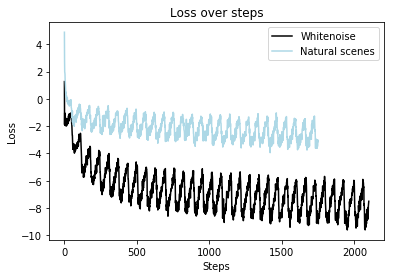

In [115]:

loss_wn = get_losses(c_wn, exp_id)
loss_ns = get_losses(c_ns, exp_id)

# Plot the training loss

plt.figure()
plt.title('Loss over steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(loss_wn,label='Whitenoise',color='black')
plt.plot(loss_ns,label='Natural scenes',color='lightblue')
plt.legend()

Here again the CNN model has an easier time predicting responses to white noise than natural scenes. It also shows an overall performance and learning rate similar to the LN model on both. 

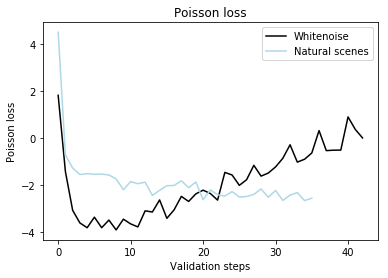

In [114]:
def get_validation_data(coll,exp_id, key1='topn_val', key2='loss'):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    return [val_steps[i]['validation_results'][key1][key2]
            for i in range(val_steps.count())]


### PLOT VALIDATION RESULTS HERE
# losses = get_validation_data('mc_colorize')
losses = get_validation_data(c_wn,exp_id, 'test_loss', 'poisson_loss')
plt.plot(losses,label='Whitenoise',color='black')
losses = get_validation_data(c_ns,exp_id, 'test_loss', 'poisson_loss')
plt.plot(losses,label='Natural scenes',color='lightblue')
plt.title('Poisson loss')
plt.legend()
plt.xlabel('Validation steps')
plt.ylabel('Poisson loss')

The poisson loss for the white noise data increases over the validation steps, suggesting that it is being overfit.

# Validation (Pearson Correlation)

In [10]:
def get_correlation_val(coll):
    # get validation data
    val_results = {}
    steps = get_steps(coll, 'trainval0')
    pearson_results = {}
    for step in steps:
        val_results[step] = {}
        val_exp_id = 'testval_step%s' % step    
        val_result = list(coll.find({'exp_id' : val_exp_id, 
                                    'validation_results' : {'$exists' : True}}, 
                                       projection=['validation_results']))
        val_results[step]['naturalscene'] = np.mean(val_result[0]['validation_results']['naturalscene_pearson'].values())
        val_results[step]['whitenoise'] = np.mean(val_result[0]['validation_results']['whitenoise_pearson'].values())
    return val_results

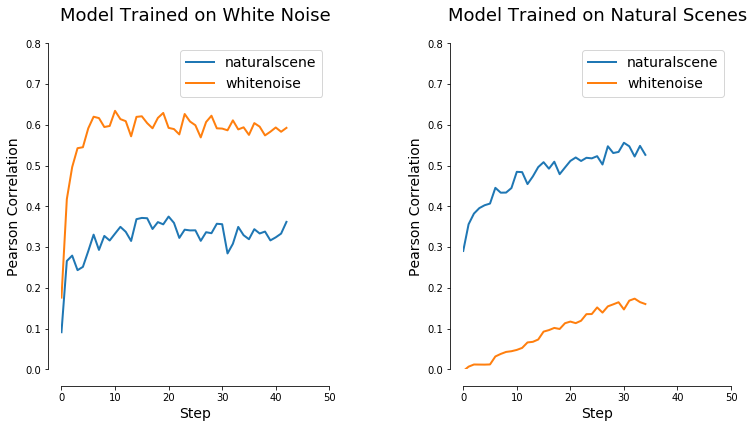

In [33]:
wn_val = get_correlation_val(c_wn)
ns_val = get_correlation_val(c_ns)

f, axes = plt.subplots(1, 2, figsize=(12,6))
ax1, ax2 = axes
ax1.plot([wn_val[s]['naturalscene'] for s in sorted(wn_val.keys())], linewidth=2, label='naturalscene')
ax1.plot([wn_val[s]['whitenoise'] for s in sorted(wn_val.keys())], linewidth=2,  label='whitenoise')
ax1.set_title('Model Trained on White Noise', fontsize=18, y=1.05)

ax2.plot([ns_val[s]['naturalscene'] for s in sorted(ns_val.keys())], linewidth=2,  label='naturalscene')
ax2.plot([ns_val[s]['whitenoise'] for s in sorted(ns_val.keys())], linewidth=2,  label='whitenoise')
ax2.set_title('Model Trained on Natural Scenes', fontsize=18, y=1.05)


for ax in [ax1, ax2]:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    ax.legend(fontsize=14)
    ax.set_ylim(0,.8)
    ax.set_xlim(0,50)
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Pearson Correlation', fontsize=14)
    
plt.subplots_adjust(wspace=.5)

As predicted, the CNN model performs better than the LN model for both within-trained and across-trained conditions. The only case which is not much better is testing on white noise after training on natural scenes. We can see that the model better correlates with neural firing in the same condition as the training condition. However, while the white noise model quickly asymptotes to a steady state, the natural scene model has not seemed to reach it's peak performance. However, it is unlikely that it will explain activity during white noise as well as the white noise-trained model.